In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')
!ls

Mounted at /content/drive
drive  sample_data


In [2]:
# move into project directory
repo_name = "Image-Colorization"
%cd /content/drive/MyDrive/Personal-Projects/$repo_name
!ls

/content/drive/MyDrive/Personal-Projects/Image-Colorization
common	     datautils	  Index.ipynb  output			 README.md
config.yaml  experiments  index.py     preprocess_imagenette.py  requirements.txt
data	     Index_bc.py  models       project-structure.md	 run.yaml


In [ ]:
# set up environment
# comment out if not required
'''
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib numpy pandas pyyaml opencv-python
'''

'\n!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118\n!pip install matplotlib numpy pandas pyyaml opencv-python\n'

In [ ]:
# this cell is for downloading data.
# as of yet data is not hosted and is available in the private data folder
#!tar -xvzf data/imagenette2-320.tgz
#!unzip -qq data/imagenette2-320-processed.zip -d data/


In [3]:
# setup some imports
#custom imports
from common.transforms import ToTensor
from datautils.datareader import DataReader
from datautils.datareader import ImagenetteReader
from datautils.dataset import CustomDataset
from datautils.dataset import CustomImagenetDataset
from common.utils import get_exp_params, init_config, get_config, save2config, get_saved_model, get_modelinfo, get_model_data
from models.unet import UNet
from models.conv_net import ConvNet
from models.custom_models import get_model

#py imports
import random
import numpy as np
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from experiments.experiments import Experiment
from common.visualization import Visualization
from experiments.test_model import ModelTester

In [4]:
# initialize directories and config data
init_config()
config = get_config()
print('Config parameters\n')
print(config)

Config parameters

{'X_key': 'L', 'data_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization/data', 'device': 'cuda', 'output_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization/output', 'root_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization', 'use_gpu': True, 'y_key': 'AB'}


In [5]:
# read experiment parameters
exp_params = get_exp_params()
print('Experiment parameters\n')
print(exp_params)

Experiment parameters

{'transform': {'resize_dim': 256, 'crop_dim': 224}, 'train': {'shuffle_data': True, 'batch_size': 32, 'val_split_method': 'fixed-split', 'k': 3, 'val_percentage': 20, 'loss': 'l1', 'epoch_interval': 5, 'num_epochs': 1000}, 'model': {'name': 'conv_net', 'optimizer': 'Adam', 'lr': 0.0001, 'weight_decay': 1e-07, 'amsgrad': True, 'momentum': 0.8, 'build_on_pretrained': False, 'pretrained_filename': '/models/checkpoints/last_model.pt'}, 'dataset': {'name': 'imagenette', 'size': 'full'}}


In [6]:
#initialize randomness seed
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [7]:
# read and load custom data

#save X_key and y_key
save2config('X_key', 'L')
save2config('y_key', 'AB')

if exp_params['dataset']['name'] == 'custom':
    #preprocess data or load preprocessed data (custom)
    dr = DataReader()
    ds = dr.get_split_data()
    Ltr, ABtr, ftr_len = ds['Ltr'], ds['ABtr'], ds['ftr_len']
    Lte, ABte, te_len = ds['Lte'], ds['ABte'], ds['te_len']
    print('Shape of X and y:', ds['Ltr'].shape, ds['ABtr'].shape)

    #transform data
    composed_transforms =  transforms.Compose([
        ToTensor()
    ])
    #convert to dataset
    ftr_dataset = CustomDataset(Ltr, ABtr, ftr_len)
    te_dataset = CustomDataset(Lte, ABte, te_len)
    smlen = int(0.01 * len(ftr_dataset))
    smftr_dataset = torch.utils.data.Subset(ftr_dataset, list(range(smlen)))
    smftrte_dataset = torch.utils.data.Subset(ftr_dataset, list(range(10)))
    smtelen = int(0.1 * len(te_dataset))
    smfte_dataset = torch.utils.data.Subset(te_dataset, list(range(smtelen)))
    print('Full train dataset length:', len(ftr_dataset))
    print('Test dataset length:', len(te_dataset))
    print('Subset train dataset length:', smlen)
    print('Subset test dataset length:', smtelen, '\n')
elif exp_params['dataset']['name'] == 'imagenette':
    dr = ImagenetteReader()
    train_paths, test_paths = dr.get_data_filepaths()
    ftr_dataset = CustomImagenetDataset(train_paths)
    te_dataset = CustomImagenetDataset(test_paths)
    smlen = int(0.01 * len(ftr_dataset))
    smftr_dataset = torch.utils.data.Subset(ftr_dataset, list(range(smlen)))
    smtelen = int(0.01 * len(te_dataset))
    smfte_dataset = torch.utils.data.Subset(te_dataset, list(range(smtelen)))
    smftrte_dataset = torch.utils.data.Subset(smftr_dataset, list(range(10)))
    print('Full train dataset length:', len(ftr_dataset))
    print('Test dataset length:', len(te_dataset))
    print('Subset train dataset length:', smlen)
    print('Subset test dataset length:', smtelen, '\n')
else:
    raise SystemError('Invalid dataset name passed!')



Full train dataset length: 9469
Test dataset length: 3925
Subset train dataset length: 94
Subset test dataset length: 39 



In [ ]:
# model training

if exp_params['dataset']['name'] == 'custom':
    if exp_params['dataset']['size'] == 'subset':
        #model training with small dataset (custom)
        exp = Experiment(exp_params["model"]["name"], smftr_dataset)
        model_history = exp.train()
    else:
        #model training with full dataset (custom)
        exp = Experiment(exp_params["model"]["name"], ftr_dataset)
        model_history = exp.train()
elif exp_params['dataset']['name'] == 'imagenette':
    if exp_params['dataset']['size'] == 'subset':
        #model training with small dataset (imagenette)
        composed_transforms =  transforms.Compose([
            #transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]),
            transforms.Resize(exp_params['transform']['resize_dim']),
            transforms.CenterCrop(exp_params['transform']['crop_dim'])
        ])
        exp = Experiment(exp_params["model"]["name"], smftr_dataset, composed_transforms, 'imagenette')
        model_history = exp.train()
    else:
        #model training with full dataset (imagenette)
        composed_transforms =  transforms.Compose([
            #transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]),
            transforms.Resize(exp_params['transform']['resize_dim']),
            transforms.CenterCrop(exp_params['transform']['crop_dim'])
        ])
        exp = Experiment(exp_params["model"]["name"], ftr_dataset, composed_transforms, 'imagenette')
        model_history = exp.train()
else:
    raise SystemError('Invalid dataset name passed!')

Running straight split
Loading saved model
	Running Epoch 992


		Running through validation set: 100%|██████████| 60/60 [01:09<00:00,  1.16s/it]


	Epoch 992 Training Loss: 0.04582844920055164
	Epoch 992 Validation Loss: 0.049699571005295526
	Running Epoch 995


		Running through validation set: 100%|██████████| 60/60 [01:14<00:00,  1.24s/it]


	Epoch 995 Training Loss: 0.04560387818636461
	Epoch 995 Validation Loss: 0.06440291782409126
	Running Epoch 1000


		Running through validation set: 100%|██████████| 60/60 [01:13<00:00,  1.23s/it]


	Epoch 1000 Training Loss: 0.04623277292222005
	Epoch 1000 Validation Loss: 0.04891294650674433



Model validation results

Model results




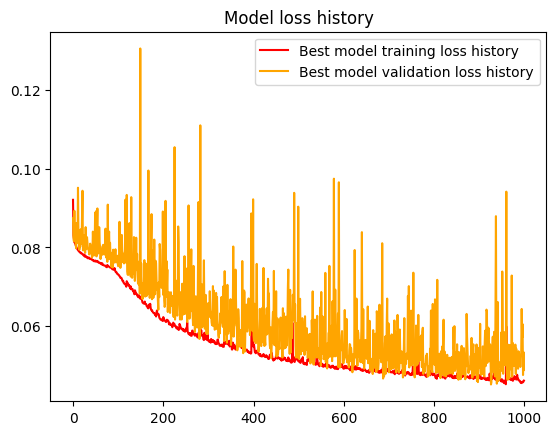


Model Training Loss: 0.04623277292222005
Model Validation Loss: 0.04891294650674433


In [ ]:
# test model on validation set

if exp_params['dataset']['name'] == 'custom' or exp_params['dataset']['name'] == 'imagenette':
    # get best model with custom dataset
    model, model_history, _ = get_model_data(exp_params["model"]["name"])
    #model = get_saved_model(model, '')
    model_info = get_modelinfo('')
    print("\nModel validation results")
    #visualization results
    vis = Visualization(model_info, model_history)
    vis.get_results()
else:
    raise SystemError('Invalid dataset name passed!')



Testing Saved Model on subset of training set


<Figure size 640x480 with 0 Axes>

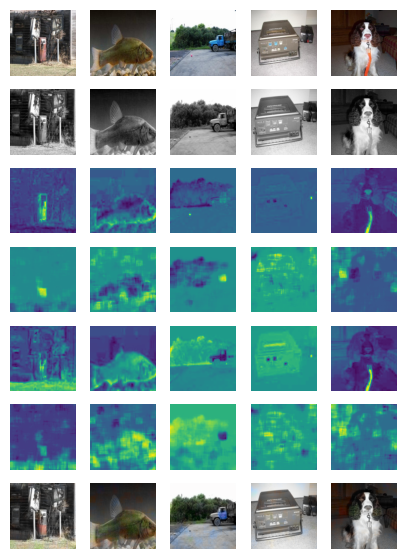


Test Loss: 0.03804093226790428
Test Accuracy: tensor(0.) 



In [ ]:
# test fine-tuned model on training set

if exp_params['dataset']['name'] == 'custom':
    #model testing with small subset of training dataset
    model = get_model(exp_params["model"]["name"])
    model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))
    print("\n\nTesting Saved Model on Training set subset")
    mt = ModelTester(model, smftrte_dataset)
    mt.test_and_plot(ds["RGBtr"], ABtr, "best_model", True)
elif exp_params['dataset']['name'] == 'imagenette':
    #model testing with small subset of training dataset (imagenette)
    composed_transforms =  transforms.Compose([
            #transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]),
            transforms.Resize(exp_params['transform']['resize_dim']),
            transforms.CenterCrop(exp_params['transform']['crop_dim'])
        ])
    model = get_model(exp_params["model"]["name"])
    model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))
    print("\n\nTesting Saved Model on subset of training set")
    mt = ModelTester(model, smftrte_dataset, composed_transforms)
    mt.test_imagenette_and_plot(True)
else:
    raise SystemError('Invalid dataset name passed!')




Testing Saved Model on full test set


<Figure size 640x480 with 0 Axes>

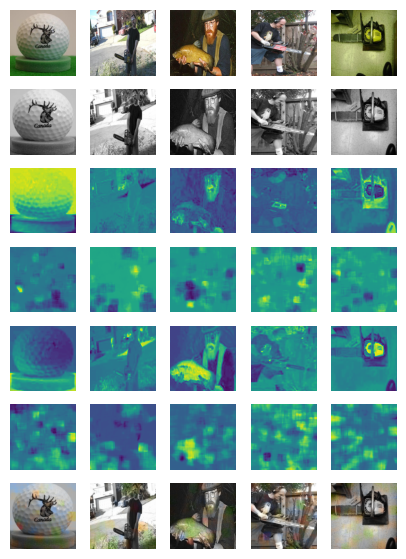

In [ ]:
# test fine-tuned model on test set
if exp_params['dataset']['name'] == 'custom':
    # model testing with small subset of training dataset
    model = get_model(exp_params["model"]["name"])
    model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))
    if exp_params['dataset']['size'] == 'subset':
        print("\n\nTesting Saved Model subset of test set")
        mt = ModelTester(model, smfte_dataset)
        mt.test_and_plot(ds["RGBte"], ABte, "best_model", True)
    else:
        print("\n\nTesting Saved Model on full test set")
        mt = ModelTester(model, te_dataset)
        mt.test_and_plot(ds["RGBte"], ABte, "best_model", True)
elif exp_params['dataset']['name'] == 'imagenette':
    # model testing with small subset of training dataset (imagenette)
    composed_transforms =  transforms.Compose([
            #transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]),
            transforms.Resize(exp_params['transform']['resize_dim']),
            transforms.CenterCrop(exp_params['transform']['crop_dim'])
        ])
    model = get_model(exp_params["model"]["name"])
    model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))
    if exp_params['dataset']['size'] == 'subset':
        print("\n\nTesting Saved Model on subset of test set")
        mt = ModelTester(model, smfte_dataset, composed_transforms)
        mt.test_imagenette_and_plot(True)
    else:
        print("\n\nTesting Saved Model on full test set")
        mt = ModelTester(model, te_dataset, composed_transforms)
        mt.test_imagenette_and_plot(True)
else:
    raise SystemError('Invalid dataset name passed!')